In [1]:
!pip install roboflow
!pip install wandb==0.15.12
!pip install ultralytics==8.0.186

# Download Dataset

I found an object detection dataset on Roboflow Universe. This dataset contains 9989 images with 4 classes:
* `ambulance`
* `label`
* `siren`
* `misc` (other type of trucks).

**Note**: You need to insert your Roboflow API key to run the cell below.

In [2]:
from getpass import getpass
from roboflow import Roboflow

rf = Roboflow(api_key=getpass())
project = rf.workspace("ph-ambulance-dataset-with-augmentations").project("ph-ambulances")
version = project.version(1)
dataset = version.download("yolov8")


··········
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.186, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to PH-Ambulances-1 in yolov8:: 100%|██████████| 19990/19990 [00:04<00:00, 4758.68it/s]


The dataset would be splitted into 3 parts when we download it.

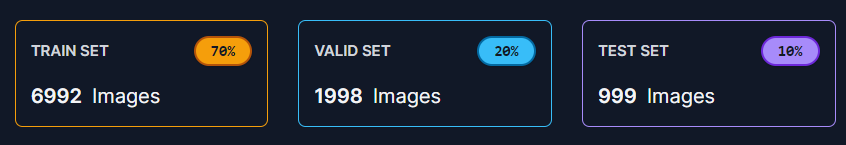

All images in this dataset are already resized into 640x640 and it also includes augmented samples. So, I don't need to do any data preparation. However, I still need to modify the labels.

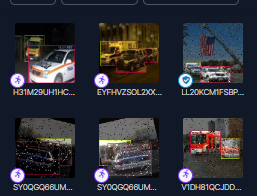

# Data Preparation

I need to convert the classes to only include 2 classes: `ambulance` and `truck`.

To do that I will rename the label directories into original labels.

In [3]:
!mv /content/PH-Ambulances-1/train/labels /content/PH-Ambulances-1/train/labels-original
!mv /content/PH-Ambulances-1/valid/labels /content/PH-Ambulances-1/valid/labels-original
!mv /content/PH-Ambulances-1/test/labels /content/PH-Ambulances-1/test/labels-original

In [4]:
# !rm -rf /content/PH-Ambulances-1/train/labels
# !rm -rf /content/PH-Ambulances-1/valid/labels
# !rm -rf /content/PH-Ambulances-1/test/labels

In [5]:
!mkdir /content/PH-Ambulances-1/train/labels
!mkdir /content/PH-Ambulances-1/valid/labels
!mkdir /content/PH-Ambulances-1/test/labels

Then, I will iterate through all the labels and convert them to only include our desired classes. Here is the label annotations:

* 0: Ambulance
* 1: Label
* 2: Truck
* 3: Siren

I will only use 0 and 2

In [6]:
import glob, os
import tqdm

usable_class = {
    '0': '0',
    '2': '1',
    '4': '2'
}

def convert_object_labels(objects):
    new_objects = []
    for object_ in objects:
        if len(object_)>0:
            class_name = object_[0]
            if class_name in usable_class:
                new_objects.append(usable_class[class_name] + object_[1:])
    return new_objects

for split in ['train', 'valid', 'test']:
    for filepath in tqdm.tqdm(glob.glob(f'/content/PH-Ambulances-1/{split}/labels-original/*.txt')):

        # Read original annotion and convert it
        with open(filepath, 'r') as f:
            objects = f.read().split('\n')
            objects = convert_object_labels(objects)

        # Write new annotation
        new_path = filepath.replace('labels-original', 'labels')
        with open(new_path, 'w') as f:
            f.write('\n'.join(objects))


100%|██████████| 999/999 [00:00<00:00, 13681.32it/s]



I need to modify the data.yaml that we will use in the training process.

In [8]:
%%writefile /content/PH-Ambulances-1/new_data.yaml

names:
- Aambulance
- truck
- object
nc: 3
roboflow:
  license: CC BY 4.0
  project: ph-ambulances
  url: https://universe.roboflow.com/ph-ambulance-dataset-with-augmentations/ph-ambulances/dataset/1
  version: 1
  workspace: ph-ambulance-dataset-with-augmentations
test: /content/PH-Ambulances-1/test/images
train: /content/PH-Ambulances-1/train/images
val: /content/PH-Ambulances-1/valid/images


Overwriting /content/PH-Ambulances-1/new_data.yaml


# Model Training

I will use ultralytics to train YOLOv8, and WandB to monitor the training process. This wandb tracking implementation includes some advanced features that we will see shortly.

In [9]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback
from PIL import Image

from ultralytics import YOLO

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



In [ ]:
wandb.init(project="kecilin-tech-assessment", job_type="training")

lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
train/box_loss,▁
train/cls_loss,▁
train/dfl_loss,▁
lr/pg0,0.00047
lr/pg1,0.00047
lr/pg2,0.00047
train/box_loss,0.0
train/cls_loss,107.27233


In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/78.2 GB disk)


I trained YOLOv8 for 10 epochs.

In [ ]:
# Initialize YOLO Model
model = YOLO("yolov8n.pt")

# Add Weights & Biases callback for Ultralytics
add_wandb_callback(model, enable_model_checkpointing=True)

# Train/fine-tune model
model.train(project="kecilin-tech-assessment", data='/content/PH-Ambulances-1/new_data.yaml', epochs=10, device=[0])
model.val()

# Finish the W&B run
wandb.finish()

New https://pypi.org/project/ultralytics/8.1.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/PH-Ambulances-1/new_data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=kecilin-tech-assessment, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visua

lr/pg0,▂▆█▇▇▆▅▃▂▁
lr/pg1,▂▆█▇▇▆▅▃▂▁
lr/pg2,▂▆█▇▇▆▅▃▂▁
metrics/mAP50(B),▃▄▁▆▆▆▇███
metrics/mAP50-95(B),▂▃▁▅▅▆▇▇▇█
metrics/precision(B),▅▄▁▅▆▇▆▇▇█
metrics/recall(B),▂▃▁▆▆▆▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇▆▅▄▄▂▂▁


# Model Evaluation

### Evaluate on test set

In [10]:
model = YOLO('best.pt', task='detect')

In [11]:
model.val()

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients
100%|██████████| 755k/755k [00:00<00:00, 32.1MB/s]
val: Scanning /content/PH-Ambulances-1/valid/labels... 1998 images, 28 backgrounds, 0 corrupt: 100%|██████████| 1998/1998 [00:01<00:00, 1510.88it/s]
val: New cache created: /content/PH-Ambulances-1/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 2297. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:24<00:00,  5.15it/s]
                   all       1998       2297      0.939      0.874      0.938      0.752
            Aambulance       1998       1981      0.946      0.865      0.951

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be67873a230>
fitness: 0.7705049125298375
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.70542,     0.79838,      0.7519])
names: {0: 'Aambulance', 1: 'truck', 2: 'object'}
plot: True
results_dict: {'metrics/precision(B)': 0.9392765761221349, 'metrics/recall(B)': 0.874065489236353, 'metrics/mAP50(B)': 0.9379743110228055, 'metrics/mAP50-95(B)': 0.7518972015861745, 'fitness': 0.7705049125298375}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.4949199783432114, 'inference': 3.970766210699224, 'loss': 0.0024647326082796665, 'postprocess': 1.8141656308560759}

When I tested the model on test set, I got 93.7% mAP@50 and 75.1% map50-9@50-95.


See the inference results here https://wandb.ai/nodeflux-internship/kecilin-tech-assessment/reports/Evaluate-on-test-set--Vmlldzo3MDk1MDUx?accessToken=3nd0lq2ii5rbtqp6h80rb6hw6828asm1jthkeompapkgk4cii9kbnuv7hoadge1a


> **Note**: From the wandb report above, we could see that the model might be biased towards detecting white trucks as ambulance.

### WandB Tracking Results

You can see the full report here: https://api.wandb.ai/links/nodeflux-internship/eiwjg81c

#### Confusion Matrix

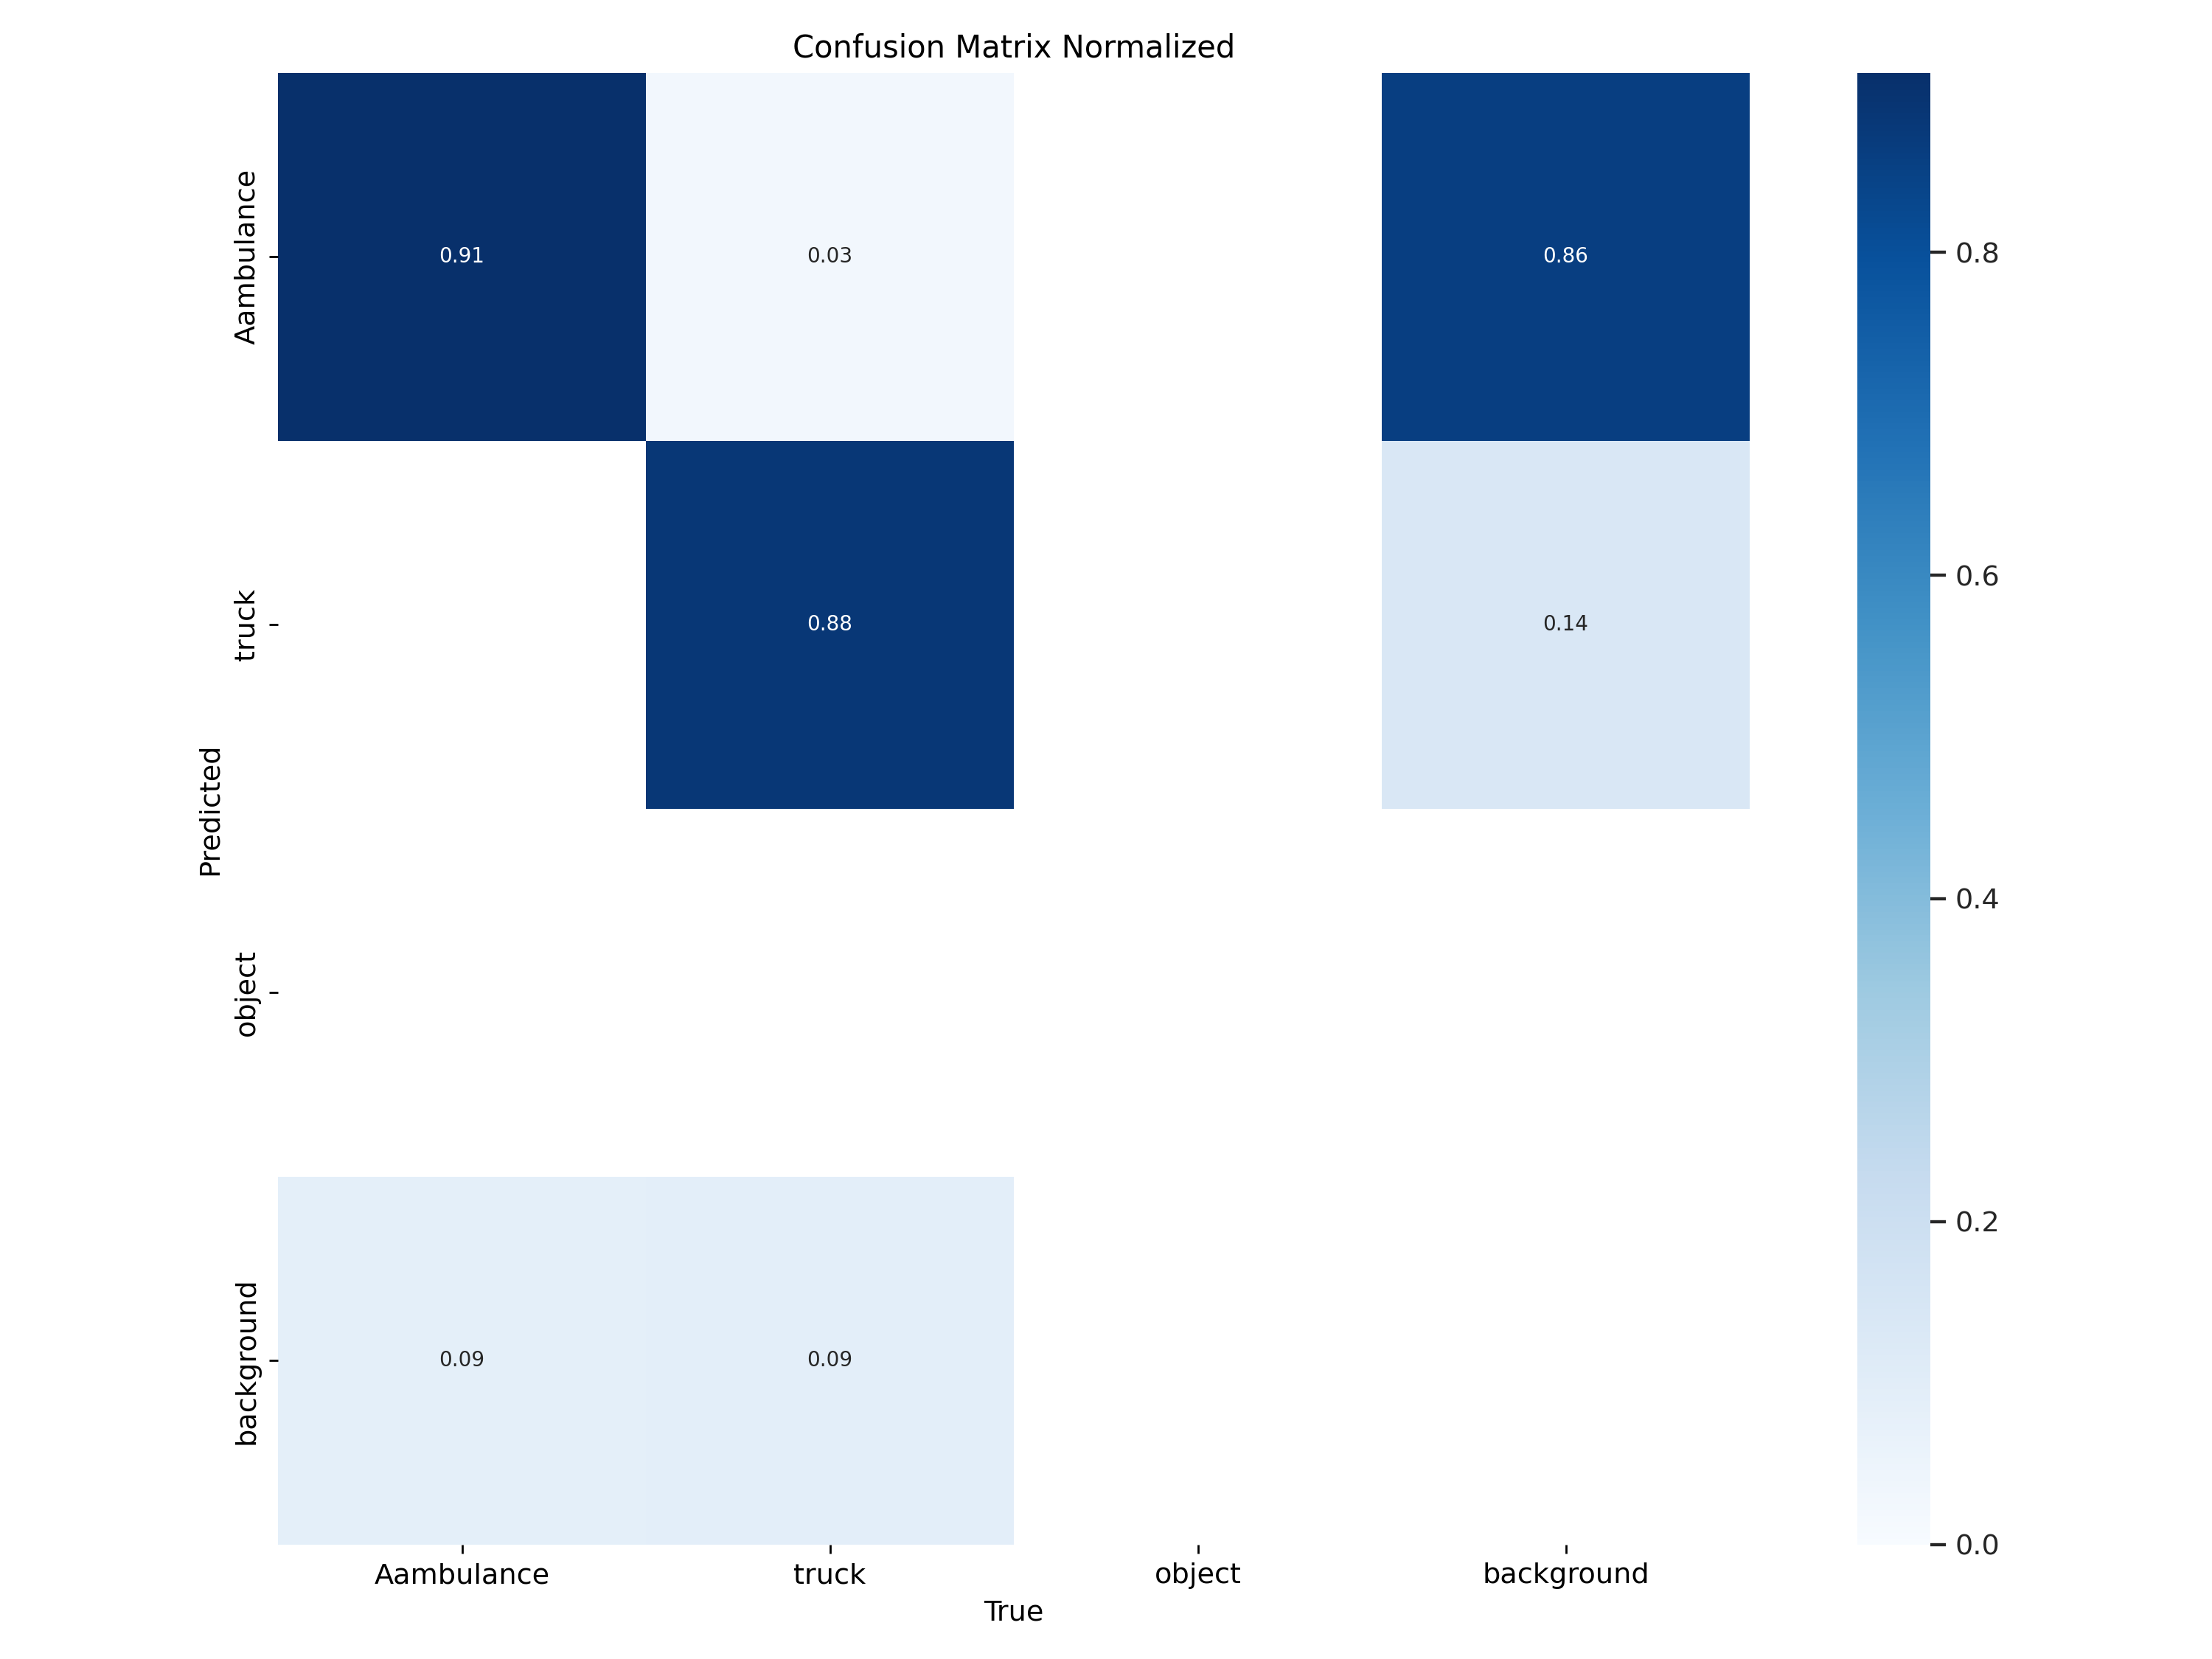

#### mean Average Precision

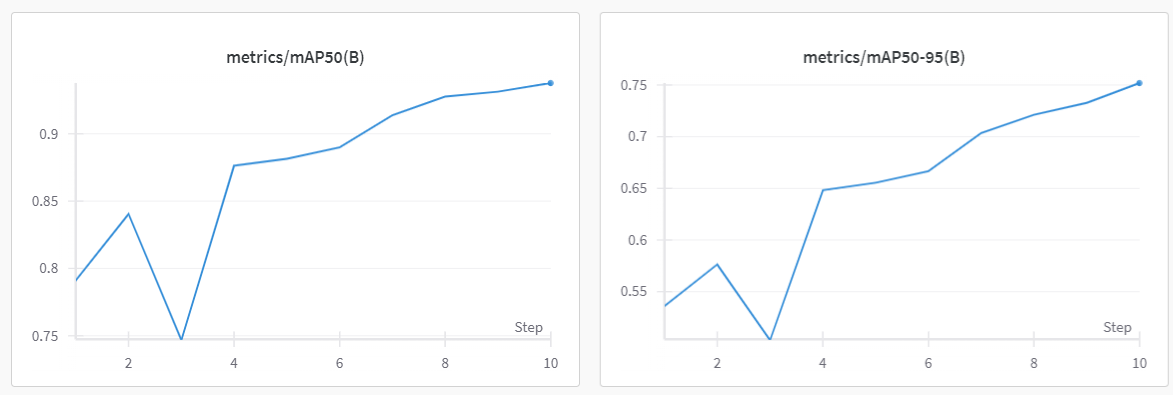

# Calculate Inference Speed

In [ ]:
wandb.init(project="kecilin-tech-assessment", job_type="evaluation")

In [ ]:
model_best = YOLO('/content/best.pt', task='detect')

In [ ]:
import glob
test_img_paths = glob.glob("/content/test-images/*")

imgs = [Image.open(path) for path in test_img_paths]

results = model_best(imgs)


0: 640x640 1 Aambulance, 1: 640x640 1 truck, 2: 640x640 1 Aambulance, 1 truck, 3: 640x640 3 Aambulances, 21.5ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
for result in results:
    print(result.path)
    print(result.speed)

/content/test-images/ambulance-2.jpeg
{'preprocess': 2.891719341278076, 'inference': 24.649381637573242, 'postprocess': 1.3843774795532227}
/content/test-images/trucks-1.jpeg
{'preprocess': 2.891719341278076, 'inference': 24.649381637573242, 'postprocess': 1.3843774795532227}
/content/test-images/trucks-2.jpeg
{'preprocess': 2.891719341278076, 'inference': 24.649381637573242, 'postprocess': 1.3843774795532227}
/content/test-images/ambulance-1.jpg
{'preprocess': 2.891719341278076, 'inference': 24.649381637573242, 'postprocess': 1.3843774795532227}


Here we get 24ms latency on inference

# Reduce Inference Speed


### Quantize the model

In this step, I will quickly quantize the model into int8 format.

In [18]:
model_best.export(format='torchscript', int8=True)

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)

TorchScript: starting export with torch 2.1.0+cu121...
TorchScript: export success ✅ 2.9s, saved as '/content/best.torchscript' (11.9 MB)

Export complete (4.5s)
Results saved to /content
Predict:         yolo predict task=detect model=/content/best.torchscript imgsz=640 int8 
Validate:        yolo val task=detect model=/content/best.torchscript imgsz=640 data=/content/PH-Ambulances-1/new_data.yaml int8 
Visualize:       https://netron.app


'/content/best.torchscript'

In [19]:
wandb.init(project="kecilin-tech-assessment", job_type="evaluation")

model_int8 = YOLO('/content/best.torchscript', task='detect')
add_wandb_callback(model_int8, enable_model_checkpointing=True)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


YOLO()

In [20]:
imgs = [Image.open(path) for path in test_img_paths]
results = model_int8(imgs)

Loading /content/best.torchscript for TorchScript inference...

0: 640x640 1 Aambulance, 1: 640x640 1 truck, 2: 640x640 1 Aambulance, 1 truck, 3: 640x640 3 Aambulances, 20.9ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
for result in results:
    print(result.path)
    print(result.speed)

/content/test-images/ambulance-2.jpeg
{'preprocess': 1.7180442810058594, 'inference': 5.229592323303223, 'postprocess': 0.9919404983520508}
/content/test-images/trucks-1.jpeg
{'preprocess': 1.7180442810058594, 'inference': 5.229592323303223, 'postprocess': 0.9919404983520508}
/content/test-images/trucks-2.jpeg
{'preprocess': 1.7180442810058594, 'inference': 5.229592323303223, 'postprocess': 0.9919404983520508}
/content/test-images/ambulance-1.jpg
{'preprocess': 1.7180442810058594, 'inference': 5.229592323303223, 'postprocess': 0.9919404983520508}


After quantization, we get 5ms on inference.

### Evaluate after quantization

Now let's test the model after quantizatoin

In [29]:
model_int8 = YOLO('/content/best.torchscript', task='detect')
model_int8.val(data='/content/PH-Ambulances-1/new_data.yaml', imgsz=640)

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Loading /content/best.torchscript for TorchScript inference...
val: Scanning /content/PH-Ambulances-1/valid/labels.cache... 1998 images, 28 backgrounds, 0 corrupt: 100%|██████████| 1998/1998 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 2297. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:25<00:00,  4.92it/s]
                   all       1998       2297      0.926      0.882      0.937      0.763
            Aambulance       1998       1981      0.935      0.879       0.95      0.712
                 truck       1998        316      0.918      0.884      0.924      0.814
Speed: 0.5ms preprocess, 3

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be5e8bf7af0>
fitness: 0.7800316604589512
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.71156,     0.81372,     0.76264])
names: {0: 'Aambulance', 1: 'truck', 2: 'object'}
plot: True
results_dict: {'metrics/precision(B)': 0.9263115112055731, 'metrics/recall(B)': 0.8817990125791239, 'metrics/mAP50(B)': 0.9365922935370529, 'metrics/mAP50-95(B)': 0.7626360345613843, 'fitness': 0.7800316604589512}
save_dir: PosixPath('runs/detect/val4')
speed: {'preprocess': 0.4792109624043599, 'inference': 3.451474674709805, 'loss': 0.001370369851052224, 'postprocess': 2.0100804301234216}

Now we get 93.6% mAP@50 and 76.2% map50-9@50-95. A very similar performance with 5x the speed!